In [ ]:
from utils import load_obj, save_obj
import random

data = load_obj("/home/sander/code/thesis/hover/data/hover/hover_dev_release_v1.1.json")
nested_dict = {
    "2": {"SUPPORTED": None, "NOT_SUPPORTED": None},
    "3": {"SUPPORTED": None, "NOT_SUPPORTED": None},
    "4": {"SUPPORTED": None, "NOT_SUPPORTED": None}}

def categorize_and_add_data(data_list, nested_dict, number_of_claims):
    #randomized
    for hop_count in nested_dict.keys():
        supported_data = [d for d in data_list if d['num_hops'] == int(hop_count) and d['label'] == 'SUPPORTED']
        not_supported_data = [d for d in data_list if d['num_hops'] == int(hop_count) and d['label'] == 'NOT_SUPPORTED']

        nested_dict[hop_count]['SUPPORTED'] = random.sample(supported_data, number_of_claims)
        nested_dict[hop_count]['NOT_SUPPORTED'] = random.sample(not_supported_data, number_of_claims)
        
    return nested_dict

number_of_claims = 5
nested_dict_updated = categorize_and_add_data(data, nested_dict, number_of_claims)

#save_obj(nested_dict_updated, "qualitative_analysis_claims.json")

In [8]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../").resolve()))
import pandas as pd
pd.set_option('display.max_colwidth', None)
from evaluate_retrieval import is_successful_retrieval
from utils import load_obj, save_obj
data = load_obj("decomposed_qualitative_analysis_retrieval.json")
tpl_list = []
for hop_count in data:
    for key in data[hop_count]:
        for item in data[hop_count][key]:
            found = []
            not_found = []
            for fact in item["supporting_facts"]:
                if fact[0] in item["retrieved"]:
                    found.append(fact[0])
                else:
                    not_found.append(fact[0])
            tpl_list.append((item["claim"],item["decomposed_claims"],item["supporting_facts"],found,not_found,hop_count, key, is_successful_retrieval(item, retrieval_key="retrieved"),item["retrieved"]))

df = pd.DataFrame(tpl_list, columns=[ "claim", "decomposed_claims",  "supporting_facts", "found","not_found","Hop Count", "Supported", "Successful Retrieval", "Retrieved Documents"])
#df_vis = pd.DataFrame(tpl_list, columns=["Hop Count", "Supported", "Successful Retrieval"])

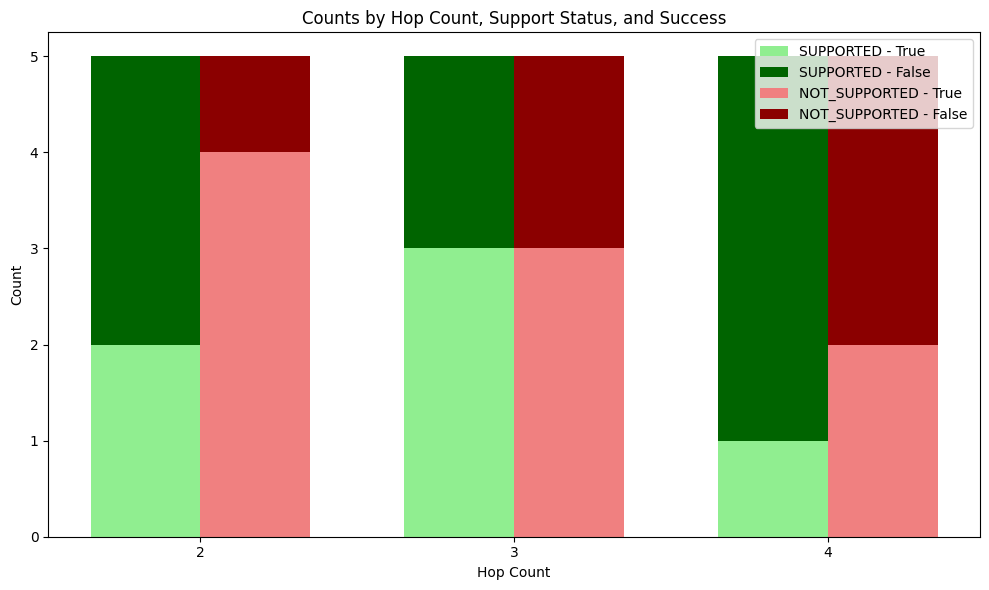

In [17]:
import numpy as np
import matplotlib.pyplot as plt
# Summarizing data for the stacked bar chart
df_vis = df[["Hop Count", "Supported", "Successful Retrieval"]]
summary = df_vis.groupby(['Hop Count', 'Supported', 'Successful Retrieval']).size().unstack(fill_value=0).reset_index()

supported_data = summary[summary['Supported'] == 'SUPPORTED']
not_supported_data = summary[summary['Supported'] == 'NOT_SUPPORTED']

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(supported_data['Hop Count'].unique()))
bar_positions_supported = index - bar_width / 2
bar_positions_not_supported = index + bar_width / 2

ax.bar(bar_positions_supported, supported_data[True], width=bar_width, label='SUPPORTED - True', color='lightgreen')
ax.bar(bar_positions_supported, supported_data[False], bottom=supported_data[True], width=bar_width, label='SUPPORTED - False', color='darkgreen')
ax.bar(bar_positions_not_supported, not_supported_data[True], width=bar_width, label='NOT_SUPPORTED - True', color='lightcoral')
ax.bar(bar_positions_not_supported, not_supported_data[False], bottom=not_supported_data[True], width=bar_width, label='NOT_SUPPORTED - False', color='darkred')

ax.set_xlabel('Hop Count')
ax.set_ylabel('Count')
ax.set_title('Counts by Hop Count, Support Status, and Success')
ax.set_xticks(index)
ax.set_xticklabels(supported_data['Hop Count'].unique())
ax.legend()

plt.tight_layout()
plt.savefig("qualitative_analysis.png")
plt.show()



In [12]:
def preprocess_supporting_facts(facts_list):  
    html_list = ''.join(f'<li>{fact[0]} (hop: {fact[1]})</li>' for fact in facts_list)
    return f"<ul>{html_list}</ul>"

def preprocess_decomposed_claims(claims):
    claims_list = claims.split("\n")
    html_list =  ''.join(f'<li>{claim.strip()}</li>' for claim in claims_list if claim.strip())
    return f"<ul>{html_list}</ul>"

def preprocess_list_column(list_items):
    html_list = ''.join(f'<li>{item}</li>' for item in list_items)
    return f"<ul>{html_list}</ul>"

df['supporting_facts'] = df['supporting_facts'].apply(preprocess_supporting_facts)
df['decomposed_claims'] = df['decomposed_claims'].apply(preprocess_decomposed_claims)
df['found'] = df['found'].apply(preprocess_list_column)
df['not_found'] = df['not_found'].apply(preprocess_list_column)
df['Retrieved Documents'] = df['Retrieved Documents'].apply(preprocess_list_column)


In [18]:
import base64

encoded_image_path = "qualitative_analysis.png"
with open(encoded_image_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()


image_html = f'<img src="data:image/png;base64,{encoded_string}" alt="Chart" style="max-width:100%;height:auto;">'

html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Retrieval Data Analysis</title>
<style>
  body {font-family: Arial, sans-serif;}
  .expandable-content {margin-bottom: 10px;}
  .expandable-content .content {display: none;}
  .expandable-content .toggle-button {cursor: pointer; color: #007bff; text-decoration: underline;}
  img {max-width: 100%; height: auto;}
  table {width: 100%; border-collapse: collapse; table-layout: fixed;}
  th, td {border: 1px solid #ddd; padding: 8px; text-align: left;}
  th {background-color: #f2f2f2; position: sticky; top: 0; z-index: 10;}
  .table-container {max-height: 400px; overflow-y: auto;}
</style>
<script>
function toggleContent(id) {
  var content = document.getElementById('content-' + id);
  var button = document.getElementById('button-' + id);
  if (content.style.display === 'none') {
    content.style.display = 'block';
    button.textContent = 'Collapse';
  } else {
    content.style.display = 'none';
    button.textContent = 'Expand';
  }
}
</script>
</head>
<body>

<h2>Data Analysis</h2>
<table>
  <tr>
    <th style="width: 50px;">Index</th>
    <th>Claim</th>
    <th>Decomposed Claims</th>
    <th>Supporting Facts</th>
    <th>Found</th>
    <th>Not Found</th>
    <th style="width: 50px;">Hop Count</th>
    <th>Supported</th>
    <th style="width: 100px;">Successful Retrieval</th>
    <th>Retrieved Documents</th>
  </tr>
"""

for index, row in df.iterrows():
    html_content += f"""
  <tr>
    <td>{index + 1}</td>
    <td>{row['claim']}</td>
    <td>{row['decomposed_claims']}</td>
    <td>{row['supporting_facts']}</td>
    <td>{row['found']}</td>
    <td>{row['not_found']}</td>
    <td>{row['Hop Count']}</td>
    <td>{row['Supported']}</td>
    <td>{row['Successful Retrieval']}</td>
    <td>
      <div class="expandable-content">
        <span id="button-{index}" class="toggle-button" onclick="toggleContent({index});">Expand</span>
        <div id="content-{index}" class="content">{row['Retrieved Documents']}</div>
      </div>
    </td>
  </tr>
"""


html_content += """
</table>

<h2>Chart</h2>
"""
html_content += image_html
html_content += """
</body>
</html>
"""

html_file_path = 'retrieval_analysis.html'
with open(html_file_path, 'w') as file:
    file.write(html_content)




FileNotFoundError: [Errno 2] No such file or directory: 'quantitative_analysis.png'